#### TSE, DEFI IA, Baseline.
#### Raphaël Sourty

In [124]:
import os
import pandas as pd
import numpy as np

### Load and clean train set:

I chose to rename some columns of the data. These data is a good example of what to avoid. In Python we should always name our columns in lower case and separate the words with an underscore. The variable "station" replaces "number_sta". I'm deliberately getting rid of the date. We won't need it, it is not defined in the test data. The day is now an integer from 0 to 729 (729 for the last day of the second year). I also created a test column that will distinguish test data from training data.

In [4]:
train = pd.read_csv(
    "data/Train/Y_train.csv", 
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int, "Ground_truth": float},
).rename(
    columns = {"Ground_truth": "y", "Id": "id", "number_sta": "station"}
).sort_values(["date", "station"]).assign(test=False)

train["month"] = train.date.dt.month.astype(int)
train["day"] = train["id"].str.split("_").str[1].astype(int)
train = train.drop("date", axis = "columns")

In [5]:
train.head()

,station,y,id,test,month,day
0,14066001,3.4,14066001_0,False,1,0
1,14126001,0.5,14126001_0,False,1,0
2,14137001,3.4,14137001_0,False,1,0
3,14216001,4.0,14216001_0,False,1,0
4,14296001,13.3,14296001_0,False,1,0


### Load and clean test:

I apply the same logic to the test data, my goal being to gather in the same dataframe the test data and the training data in order to calculate the features more easily.

In [6]:
test = pd.read_csv(
    "data/Test/Baselines/Baseline_observation_test.csv",
    dtype = {"Prediction": float}
).assign(Prediction=None, test=True).rename(columns = {"Prediction": "y", "Id": "id", "number_sta": "station"})

test["day"] = test["id"].str.split("_").str[1].astype(int)

test = pd.merge(
    left = test,
    right = pd.read_csv("data/Test/Id_month_test.csv").rename(columns = {"day_index": "day"}),
    on = ["day"],
    how = "left",
)

test["station"] = test["id"].str.split("_").str[0].astype(int)

In [7]:
test.head()

,id,y,test,day,month,station
0,14066001_149,None,True,149,1,14066001
1,14126001_149,None,True,149,1,14126001
2,14137001_149,None,True,149,1,14137001
3,14216001_149,None,True,149,1,14216001
4,14296001_149,None,True,149,1,14296001


#### Concat training set and test set:

The training and test data are formatted in the same way, so we can concatenate them. The df dataframe will now be the main dataset. We will add the features to this datafarame `df`. Features are new columns to help us estimate the target variable, we create these features manually. I also choose to delete the `id` column because I can easily find it from the station variable and the day variable.

In [8]:
df = pd.concat([train, test], axis = "rows")
df = df.drop("id", axis = "columns")
df.head()

,station,y,test,month,day
0,14066001,3.4,False,1,0
1,14126001,0.5,False,1,0
2,14137001,3.4,False,1,0
3,14216001,4.0,False,1,0
4,14296001,13.3,False,1,0


#### Station latitude, longitude, height

I will add to the df dataframe `df` the latitude and longitude data set.

In [9]:
stations = pd.read_csv(
    "data/Other/stations_coordinates.csv",
    dtype = {"number_sta": int}         
).rename(
    columns={"number_sta": "station", "lat": "latitude", "lon": "longitude", "height_sta": "height"}
)

In [10]:
stations.head()

,station,latitude,longitude,height
0,86118001,46.477,0.985,120.0
1,86149001,46.917,0.025,60.0
2,56081003,48.050,-3.660,165.0
3,53215001,47.790,-0.710,63.0
4,22135001,48.550,-3.380,148.0


In [11]:
df = pd.merge(
    left = df,
    right = stations,
    on = "station",
    how = "left",
)

In [12]:
df.head()

,station,y,test,month,day,latitude,longitude,height
0,14066001,3.4,False,1,0,49.334,-0.431,2.0
1,14126001,0.5,False,1,0,49.145,0.042,125.0
2,14137001,3.4,False,1,0,49.180,-0.456,67.0
3,14216001,4.0,False,1,0,48.928,-0.149,155.0
4,14296001,13.3,False,1,0,48.795,-1.037,336.0


#### Loading the training features:

The files `data/Test/X_station_test.csv` and `data/Train/X_station_train.csv` contain the available weather stations records with a fine granularity (record per station and per hour). We will use this data to enrich the `df` dataframe that we have previously created. We will have to aggregates those features to add them to our dataframe `df`.

First I will start by loading these data and cleaning them.

In [13]:
train_features = pd.read_csv(
    "data/Train/X_station_train.csv", 
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int},
).rename(
    columns = {"number_sta": "station", "Id": "id"}
).assign(test=False)

train_features["month"] = train_features["date"].dt.month.astype(int)
train_features["day"] = train_features["id"].str.split("_").str[1].astype(int)
train_features["hour"] = train_features["date"].dt.hour.astype(int)

train_features = train_features.drop(["date", "id"], axis = "columns")

In [14]:
train_features.head()

,station,ff,t,td,hu,dd,precip,test,month,day,hour
0,14066001,3.05,279.28,277.97,91.4,200.0,0.0,False,1,0,0
1,14066001,2.57,278.76,277.45,91.4,190.0,0.0,False,1,0,1
2,14066001,2.26,278.27,277.02,91.7,181.0,0.0,False,1,0,2
3,14066001,2.62,277.98,276.95,93.0,159.0,0.0,False,1,0,3
4,14066001,2.99,277.32,276.72,95.9,171.0,0.0,False,1,0,4


#### Loading the test features:

I apply the same logic to the test features to be able to concatenate all the test and train features. We can then build aggregates and join them to the `df` dataframe.

In [15]:
test_features = pd.read_csv(
    "data/Test/X_station_test.csv", 
).rename(
    columns = {"Id": "id"}
).assign(test=True)

In [16]:
test_features["station"] = test_features["id"].str.split("_").str[0].astype(int)
test_features["day"] = test_features["id"].str.split("_").str[1].astype(int)
test_features["hour"] = test_features["id"].str.split("_").str[2].astype(int)

In [17]:
test_features = test_features.drop(["id"], axis = "columns")

#### Features

I now create the `features` dataframe. This dataframe will contain all the records useful for creating features for the `df` data set.

In [18]:
features = pd.concat([train_features, test_features], axis = "rows")

In [19]:
features.head()

,station,ff,t,td,hu,dd,precip,test,month,day,hour
0,14066001,3.05,279.28,277.97,91.4,200.0,0.0,False,1,0,0
1,14066001,2.57,278.76,277.45,91.4,190.0,0.0,False,1,0,1
2,14066001,2.26,278.27,277.02,91.7,181.0,0.0,False,1,0,2
3,14066001,2.62,277.98,276.95,93.0,159.0,0.0,False,1,0,3
4,14066001,2.99,277.32,276.72,95.9,171.0,0.0,False,1,0,4


#### New Features

Let's start create new features since we have our two clean dataframes `df` and `features`. Our main objective will be to create aggregates of the `features` dataframe and then perform left-join to the `df` dataframe.

In [20]:
def make_agg(x, on, by, how):
    """Function to make aggregates easilly.
    
    Parameters
    ----------
        x (pd.DataFrame): Features dataframe.
        on (list): List of targets aggregates.
        by (list): List of columns we will use to group data.
        how (list): List of statistics.
    
    """
    columns = []
    for col in on:
        for stat in how:
            columns.append(f"{stat}_{col}_by_{'_'.join(by)}")
    x = x.groupby(by)[on].agg(how)  
    x.columns = columns
    return x
    

For example, here is a set of features that might be useful. We compute the mean, sum and standard deviation of variables `["ff", "t", "td", "hu", "dd", "precip"]` grouped by `["station", "day"]`.

In [21]:
make_agg(
    x = features, 
    on = ["ff", "t", "td", "hu", "dd", "precip"], 
    by = ["station", "day"], 
    how = ["mean", "sum", "std"]
)

mean_ff_by_station_day  sum_ff_by_station_day  \
station  day                                                  
14047002 31                      NaN                   0.00   
         39                      NaN                   0.00   
         100                     NaN                   0.00   
         223                     NaN                   0.00   
         236                     NaN                   0.00   
...                              ...                    ...   
95690001 725                7.699167                 184.78   
         726                8.134167                 195.22   
         727                3.172500                  76.14   
         728                6.341250                 152.19   
         729                8.529583                 204.71   

              std_ff_by_station_day  mean_t_by_station_day  \
station  day                                                 
14047002 31                     NaN             281.276250   
         39                     NaN             283.776250   
         100                    NaN             282.565000   
         223                    NaN             285.415000   
         236                    NaN             283.064167   
...                             ...                    ...   
95690001 725               1.966402             279.041667   
         726               2.592839             277.274583   
         727               1.459256             275.019583   
         728               2.948950             277.452500   
         729               1.349546             285.330833   

              sum_t_by_station_day  std_t_by_station_day  \
station  day                                               
14047002 31                6750.63              1.174193   
         39                6810.63              1.232110   
         100               6781.56              0.407057   
         223               6849.96              0.713576   
         236               6793.54              0.540442   
...                            ...                   ...   
95690001 725               6697.00              1.008614   
         726               6654.59              1.363101   
         727               6600.47              1.570075   
         728               6658.86              2.731512   
         729               6847.94              2.115520   

              mean_td_by_station_day  sum_td_by_station_day  \
station  day                                                  
14047002 31                      NaN                   0.00   
         39                      NaN                   0.00   
         100                     NaN                   0.00   
         223                     NaN                   0.00   
         236                     NaN                   0.00   
...                              ...                    ...   
95690001 725              276.800000                6643.20   
         726              275.160417                6603.85   
         727              273.014583                6552.35   
         728              275.341250                6608.19   
         729              283.395417                6801.49   

              std_td_by_station_day  mean_hu_by_station_day  \
station  day                                                  
14047002 31                     NaN                     NaN   
         39                     NaN                     NaN   
         100                    NaN                     NaN   
         223                    NaN                     NaN   
         236                    NaN                     NaN   
...                             ...                     ...   
95690001 725               0.635049               85.587500   
         726               1.975703               86.275000   
         727               0.955560               86.816667   
         728               1.946016               86.637500   
         729               1.7

We just have to join these new features with the `pd.merge` method:

In [22]:
agg = make_agg(
    x = features, 
    on = ["ff", "t", "td", "hu", "dd", "precip"], 
    by = ["station", "day"], 
    how = ["mean", "sum", "std"]
)


df = pd.merge(
    left = df,
    right = agg,
    on = ["station", "day"],
    how = "left",
)

#### Todo: add features

#### Train test split:

We separate the test game from the training game here to proceed with the model training and inference.

In [46]:
# The "test" column is a boolean column which is equal to True for test and False for train.
X_train = df[df["test"] == False].copy()
X_test = df[df["test"]].copy()

Some of the samples in the target variable are missing, we will drop it for now but it could be interesting to retrieve them:

In [47]:
X_train = X_train[X_train["y"].notnull()]

# y_train is the target variable to train our model.
y_train = X_train["y"].astype(float).copy()

We re-create the id for the submission and set it as the index of X_test

In [48]:
X_test["id"] = X_test["station"].astype(str) + "_" + X_test["day"].astype(str)
X_test = X_test.set_index("id")

We will need to drop some columns to avoid errors such as station, test and day and y. 

In [49]:
columns_to_drop = ["y", "test"]

X_train = X_train.drop(columns_to_drop, axis = "columns")
X_test = X_test.drop(columns_to_drop, axis = "columns")

In [50]:
X_train.head()

,station,month,day,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,std_ff_by_station_day,mean_t_by_station_day,...,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
0,14066001,1,0,49.334,-0.431,2.0,3.641875,174.81,1.044607,279.904167,...,1.229843,88.858333,4265.2,9.340961,176.625000,8478.0,36.306394,0.008333,0.4,0.040388
1,14126001,1,0,49.145,0.042,125.0,NaN,0.00,NaN,279.723958,...,1.477597,94.302083,4526.5,6.564524,NaN,0.0,NaN,0.020833,1.0,0.100970
2,14137001,1,0,49.180,-0.456,67.0,4.416458,211.99,1.946752,279.648125,...,1.435294,90.820833,4359.4,8.048971,170.916667,8204.0,35.328750,0.004255,0.2,0.029173
3,14216001,1,0,48.928,-0.149,155.0,3.727292,178.91,1.789319,279.662500,...,1.215815,89.404167,4291.4,8.507793,186.125000,8934.0,36.127802,0.012500,0.6,0.063998
4,14296001,1,0,48.795,-1.037,336.0,NaN,0.00,NaN,278.587917,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.004167,0.2,0.028868


In [51]:
X_test.head()

,station,month,day,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,std_ff_by_station_day,mean_t_by_station_day,...,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
id,,,,,,,,,,,,,,,,,,,,,
14066001_149,14066001,1,149,49.334,-0.431,2.0,5.111875,245.37,1.379676,284.672292,...,3.137449,84.187500,4041.0,5.007255,195.166667,9368.0,104.800181,0.029167,1.4,0.202073
14126001_149,14126001,1,149,49.145,0.042,125.0,NaN,0.00,NaN,283.686458,...,3.320618,94.531250,4537.5,3.839058,NaN,0.0,NaN,0.093750,4.5,0.352140
14137001_149,14137001,1,149,49.180,-0.456,67.0,4.645417,222.98,1.701881,283.993750,...,3.333271,85.450000,4101.6,6.475781,241.145833,11575.0,70.503656,0.008333,0.4,0.057735
14216001_149,14216001,1,149,48.928,-0.149,155.0,3.275208,157.21,1.082365,283.404583,...,3.680259,88.864583,4265.5,8.111339,272.520833,13081.0,69.952260,0.104167,5.0,0.430714
14296001_149,14296001,1,149,48.795,-1.037,336.0,NaN,0.00,NaN,282.623542,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.075000,3.6,0.390581


#### Handle missing values:

I choose to replace the missing values by -1, there are surely better solutions to replace the missing values.

In [52]:
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

#### Cross-validation

I choose here to use the LightGbm model. It is a very powerful model that wins most of the machine learning competitions. It is interesting because we can use it to measure the weight of features in the decision making of the model. Moreover, the Lightgbm API is quite practical. It is important to look for the best model parameters.

In the framework of the tutorials we will use many other models. The winning solution of the DEFI AI contest will be built from a set of models. We will come back to this later.

Documentation to install LightGBM: [lightgbm](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html).

In [53]:
import lightgbm as lgbm

from sklearn import model_selection
from sklearn import metrics

#  Fold:
k = 5

cv = model_selection.KFold(k, shuffle=True, random_state=42)

model = lgbm.LGBMRegressor(
    n_estimators=500, # Number of trees
    objective="l2",
    random_state=42,
)

error_validation = 0

sub = pd.Series(0.0, index=X_test.index)

for fit_idx, val_idx in cv.split(X_train, y_train):

    X_fit = X_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    
    y_fit = y_train.iloc[fit_idx] 
    y_val = y_train.iloc[val_idx]

    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=("fit", "val"),
        eval_metric="l2",
        early_stopping_rounds = 200,
        feature_name=X_fit.columns.tolist(),
        verbose=50,
    )
    
    # Validation predictions:
    error_validation += metrics.mean_absolute_percentage_error(
        y_true = model.predict(X_val) + 1, 
        y_pred = y_val + 1,
    ) / k
    
    # Bagging
    # Since we train 5 models using cross-validation with k=5 folds, we average the prediction of each models.
    # It helps a lot!
    sub += model.predict(X_test) / k
    
# To avoid zero-division errors, METEO FRANCE added 1 to the target variable, so we do it too.
sub += 1

D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.1231	val's l2: 11.6442
[100]	fit's l2: 9.59717	val's l2: 10.4744
[150]	fit's l2: 8.5951	val's l2: 9.71755
[200]	fit's l2: 7.92369	val's l2: 9.25186
[250]	fit's l2: 7.39691	val's l2: 8.92193
[300]	fit's l2: 6.93297	val's l2: 8.62225
[350]	fit's l2: 6.55733	val's l2: 8.38245
[400]	fit's l2: 6.21385	val's l2: 8.17843
[450]	fit's l2: 5.93805	val's l2: 8.03257
[500]	fit's l2: 5.67703	val's l2: 7.90424


D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.1002	val's l2: 11.9473
[100]	fit's l2: 9.53783	val's l2: 10.729
[150]	fit's l2: 8.573	val's l2: 10.0486
[200]	fit's l2: 7.76911	val's l2: 9.49849
[250]	fit's l2: 7.16414	val's l2: 9.10265
[300]	fit's l2: 6.72641	val's l2: 8.83416
[350]	fit's l2: 6.37604	val's l2: 8.6346
[400]	fit's l2: 6.07949	val's l2: 8.48281
[450]	fit's l2: 5.75707	val's l2: 8.30124
[500]	fit's l2: 5.54742	val's l2: 8.21053


D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.3567	val's l2: 11.7518
[100]	fit's l2: 9.78003	val's l2: 10.6056
[150]	fit's l2: 8.77285	val's l2: 9.86442
[200]	fit's l2: 8.03754	val's l2: 9.32358
[250]	fit's l2: 7.47581	val's l2: 8.96627
[300]	fit's l2: 7.00811	val's l2: 8.65745
[350]	fit's l2: 6.65057	val's l2: 8.45229
[400]	fit's l2: 6.29769	val's l2: 8.2351
[450]	fit's l2: 5.98934	val's l2: 8.05365
[500]	fit's l2: 5.71801	val's l2: 7.90879


D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.184	val's l2: 11.8273
[100]	fit's l2: 9.62976	val's l2: 10.5662
[150]	fit's l2: 8.71204	val's l2: 9.92196
[200]	fit's l2: 7.94271	val's l2: 9.35909
[250]	fit's l2: 7.40737	val's l2: 9.00425
[300]	fit's l2: 6.92547	val's l2: 8.68654
[350]	fit's l2: 6.56669	val's l2: 8.47824
[400]	fit's l2: 6.26737	val's l2: 8.29846
[450]	fit's l2: 6.00062	val's l2: 8.17744
[500]	fit's l2: 5.74158	val's l2: 8.03673


D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 11.3608	val's l2: 11.3558
[100]	fit's l2: 9.75899	val's l2: 10.0681
[150]	fit's l2: 8.79131	val's l2: 9.38189
[200]	fit's l2: 8.00682	val's l2: 8.79536
[250]	fit's l2: 7.41254	val's l2: 8.41678
[300]	fit's l2: 6.93654	val's l2: 8.10586
[350]	fit's l2: 6.55837	val's l2: 7.90913
[400]	fit's l2: 6.24944	val's l2: 7.73625
[450]	fit's l2: 5.97303	val's l2: 7.61431
[500]	fit's l2: 5.75192	val's l2: 7.51702


#### Your main goal is to reduce the value of this metric, i.e. make fewer errors. If you create a feature that does not reduce MAPE then you can throw it away. For each feature you create, you should re-execute the notebook and verify that the feature helps. The order in which you create the features does not matter. You should start by building the simplest features.

In [54]:
print(f"MAPE on validation set: {error_validation}")

MAPE on validation set: 0.45839245672571854


#### Weight of our features

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

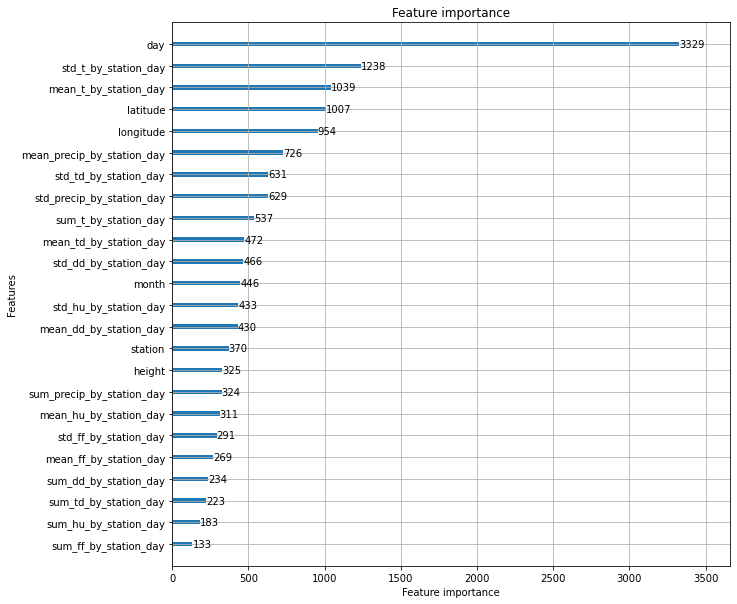

In [55]:
lgbm.plot_importance(model._Booster, figsize=(10, 10))

In [92]:
df.head()

,station,y,test,month,day,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,...,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
0,14066001,3.4,False,1,0,49.334,-0.431,2.0,3.641875,174.81,...,1.229843,88.858333,4265.2,9.340961,176.625000,8478.0,36.306394,0.008333,0.4,0.040388
1,14126001,0.5,False,1,0,49.145,0.042,125.0,NaN,0.00,...,1.477597,94.302083,4526.5,6.564524,NaN,0.0,NaN,0.020833,1.0,0.100970
2,14137001,3.4,False,1,0,49.180,-0.456,67.0,4.416458,211.99,...,1.435294,90.820833,4359.4,8.048971,170.916667,8204.0,35.328750,0.004255,0.2,0.029173
3,14216001,4.0,False,1,0,48.928,-0.149,155.0,3.727292,178.91,...,1.215815,89.404167,4291.4,8.507793,186.125000,8934.0,36.127802,0.012500,0.6,0.063998
4,14296001,13.3,False,1,0,48.795,-1.037,336.0,NaN,0.00,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.004167,0.2,0.028868


In [94]:
df.station.nunique()

323

In [95]:
df.day.nunique()

730

In [171]:
df_train = df[df.test==False].fillna(-1)
nb_day_station = df_train.station.value_counts()
df_train = df_train[df_train.station.isin(nb_day_station[nb_day_station == 730].index)]

y_train = df_train.y.astype(float).copy()
columns_to_drop = ["y", "test"]
X_train = df_train.drop(columns_to_drop, axis = "columns")
X_train = np.array(list(X_train.groupby('station').apply(np.array)))

y_train = np.array(list(df_train.groupby('station').y.apply(np.array)))

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [172]:
y_train

array([[ 3.4, 11.7,  0.6, ...,  3.2,  4.4, 12.6],
       [ 0.5,  3.5,  0. , ...,  3.5,  3.5,  5. ],
       [ 3.4,  8.4,  0.4, ...,  6.4,  5.8, 10.8],
       ...,
       [ 2.4, 10.2,  3.8, ...,  1.2,  5.6,  3.2],
       [ 0.4, 12.8,  0.8, ...,  1.6,  5.6,  1.8],
       [ 0.6,  9.2,  0.2, ...,  7.3,  5.6,  1.6]], dtype=float32)

In [147]:
X_train.shape

(234, 730, 24)

In [152]:
y_train.shape

(234, 730)

In [120]:
df_train.shape

(170820, 26)

In [98]:
df[df.test==True].shape

(85140, 26)

In [99]:
df[df.test==False].shape

(183747, 26)

In [93]:
df.shape

(268887, 26)

In [91]:
full_data = pd.merge(df.station.drop_duplicates(), df.day.drop_duplicates(), how="cross")
df_bis = pd.merge(full_data, df, on=['station', 'day'], how='left')
df_bis.shape

(310463, 26)

In [90]:
full_data.shape

(235790, 2)

In [142]:
df_train.head()

,station,month,day,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,std_ff_by_station_day,mean_t_by_station_day,...,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
0,14066001,1,0,49.334,-0.431,2.0,3.641875,174.81,1.044607,279.904167,...,1.229843,88.858333,4265.2,9.340961,176.625000,8478.0,36.306394,0.008333,0.4,0.040388
1,14126001,1,0,49.145,0.042,125.0,NaN,0.00,NaN,279.723958,...,1.477597,94.302083,4526.5,6.564524,NaN,0.0,NaN,0.020833,1.0,0.100970
2,14137001,1,0,49.180,-0.456,67.0,4.416458,211.99,1.946752,279.648125,...,1.435294,90.820833,4359.4,8.048971,170.916667,8204.0,35.328750,0.004255,0.2,0.029173
3,14216001,1,0,48.928,-0.149,155.0,3.727292,178.91,1.789319,279.662500,...,1.215815,89.404167,4291.4,8.507793,186.125000,8934.0,36.127802,0.012500,0.6,0.063998
4,14296001,1,0,48.795,-1.037,336.0,NaN,0.00,NaN,278.587917,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.004167,0.2,0.028868


In [144]:
X_train[0][2]

array([ 1.40660010e+07,  1.00000000e+00,  2.00000000e+00,  4.93340000e+01,
       -4.31000000e-01,  2.00000000e+00,  5.32187500e+00,  2.55450000e+02,
        1.66021744e+00,  2.83175833e+02,  1.35924400e+04,  2.57892509e+00,
        2.80189792e+02,  1.34491100e+04,  1.62310510e+00,  8.23812500e+01,
        3.95430000e+03,  9.14010699e+00,  1.91104167e+02,  9.17300000e+03,
        3.37621465e+01,  3.56250000e-01,  1.71000000e+01,  6.61367458e-01])

In [160]:
X_train

array([[[1.40660010e+07, 1.00000000e+00, 0.00000000e+00, ...,
         8.33333333e-03, 4.00000000e-01, 4.03881873e-02],
        [1.40660010e+07, 1.00000000e+00, 1.00000000e+00, ...,
         7.08333333e-02, 3.40000000e+00, 2.38754154e-01],
        [1.40660010e+07, 1.00000000e+00, 2.00000000e+00, ...,
         3.56250000e-01, 1.71000000e+01, 6.61367458e-01],
        ...,
        [1.40660010e+07, 1.20000000e+01, 7.27000000e+02, ...,
         1.00000000e-01, 2.40000000e+00, 2.57073835e-01],
        [1.40660010e+07, 1.20000000e+01, 7.28000000e+02, ...,
         1.33333333e-01, 3.20000000e+00, 2.40771706e-01],
        [1.40660010e+07, 1.20000000e+01, 7.29000000e+02, ...,
         1.83333333e-01, 4.40000000e+00, 4.08248290e-01]],

       [[1.41260010e+07, 1.00000000e+00, 0.00000000e+00, ...,
         2.08333333e-02, 1.00000000e+00, 1.00970468e-01],
        [1.41260010e+07, 1.00000000e+00, 1.00000000e+00, ...,
         1.08695652e-02, 5.00000000e-01, 7.37209781e-02],
        [1.41260010e+07, 

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

def lstm_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=X_train.shape[1:], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_absolute_percentage_error')
    
    return model

lstm_model().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 32)                7296      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,329
Trainable params: 7,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = lstm_model()
model.fit(X_train, y_train, epochs=2, batch_size=10, verbose=2)

Epoch 1/2
24/24 - 48s - loss: 910992998400.0000 - mean_absolute_percentage_error: 271422857412608.0000 - 48s/epoch - 2s/step
Epoch 2/2


#### Our submission:

In [33]:
sub = sub.rename("Prediction").reset_index().rename(columns = {"id": "Id"})

In [34]:
sub.to_csv("submission.csv", index=False)
sub

,Id,Prediction
0,14066001_149,3.265866
1,14126001_149,3.376589
2,14137001_149,3.141412
3,14216001_149,2.658449
4,14296001_149,5.792950
...,...,...
85135,86137003_293,1.202024
85136,86165005_293,1.081024
85137,86273001_293,3.102655
85138,91200002_293,0.804581


#### How to improve this notebook:

- Create a lots of features that reduce the MAPE
- Handle missing values
- Handle outliers, i.e extreme values
- Tune the hyperparameters of your model
- Create multiples models (Blending / Stacking)

- Predict the error rather that the target variable directly, [METEO FRANCE MODELS LINK, available soon](https://meteonet.umr-cnrm.fr/dataset/data/defi_ia_challenge/).


#### Useful resources:

https://maxhalford.github.io/blog/target-encoding/

https://explained.ai/gradient-boosting/